# Choosing the correct frequencies

In [1]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm

In [2]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

class SyntheticBinary(object):
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            M = tt.zeros_like(tt.constant(self.time)) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = (- (1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            
            self.flux_true += A_j * np.cos(omega * (self.time - self.tau)) + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, noise=0.05):
        # Add noise
        self.flux_err = noise * np.std(self.flux_true)
        self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))
        
    @staticmethod
    def quick_star(self, star='dsct', mission='kepler'):
        if star == 'dsct':
            pass

The default behaviour in Maelstrom is to estimate a set of frequencies for the model if none are supplied. While in most cases, these frequencies are fine, there are cases where special care must be taken. Let's first generate a synthetic light curve with TESS sampling. We'll consider a very rapidly oscillating star (frequency of 300 cpd), in a binary system with period 5 d. This is a rather unusual system, but we'll use it to prove a point.

In [16]:
period = 5.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

n_freqs = 1
freqs = [300.]
amps = [1]

time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs,amps,
                     period, eccen, asini, varpi, tref)

lc.add_noise(noise=0.5)


Now, let's ask Maelstrom to have a quick look at the star for any time delay signal.

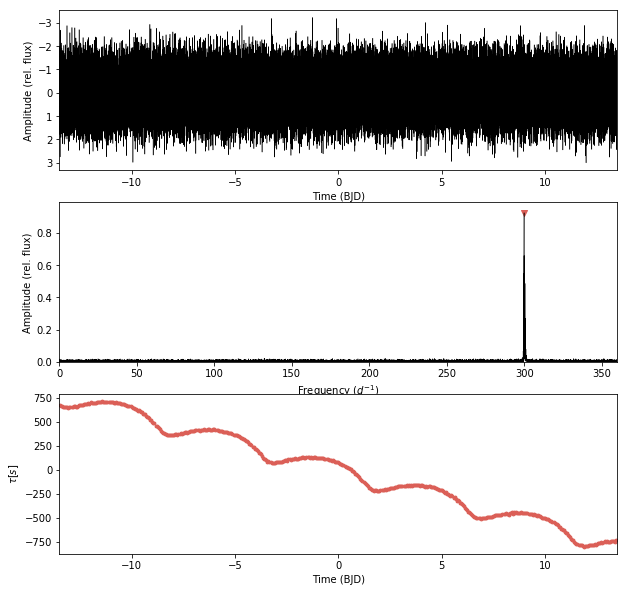

In [18]:
from maelstrom import Maelstrom
ms = Maelstrom(lc.time, lc.flux, 
              max_peaks=1
              )
ms.first_look(segment_size=0.05)

What? What's going on there! You'll notice that the time delay signal seems to be steadily decreasing over time. We can see the binary motion, but if we try and it it we'll get some nonsense back out. Maelstrom wasn't designed for this!

In fact, this motion is caused by Maelstrom incorrectly picking out the correct frequency. Frequency modulation (see Kurtz et al) causes a series of sidelobes to manifest in the amplitude spectrum. In some cases, such as stars with high frequency and low orbital period, these sidelobes can have higher amplitudes than the true frequency. So, let's take a closer look at the synthetic data by calculating the amplitude spectrum.

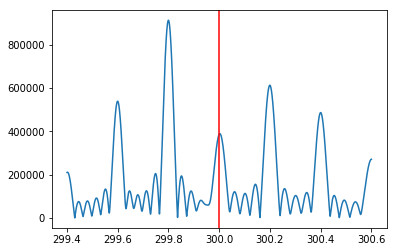

In [22]:
from astropy.stats import LombScargle

N = 100000
fmin, fmax = freqs[0]-3*(1/period), freqs[0]+3*(1/period)
freq = np.linspace(fmin, fmax, N)
model = LombScargle(lc.time, lc.flux)
sc = model.power(freq, method="fast", normalization="psd")

fct = np.sqrt(4./len(lc.time))
amp = np.sqrt(sc) * fct
amp /= 1e-6

plt.plot(freq,amp)
plt.axvline(300., c='r')

You'll notice that the true frequency at 300 cpd is split on both sides by a series of peaks. These peaks separated by the orbital frequency of the binary system (1/Porb). When Maelstrom looks for the frequency, it grabs the highest peak and optimizes that. Indeed, if we grab the sidelobe immediately to the right of the central peak, we'll notice that the time delay signal is instead increasing over time:

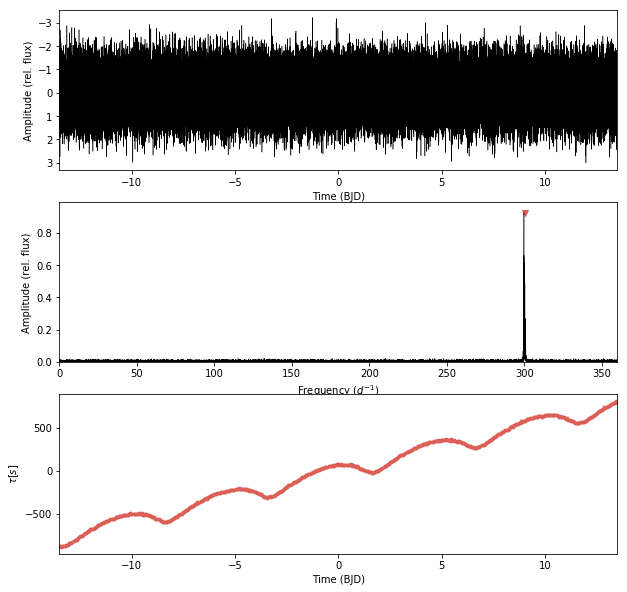

In [26]:
from maelstrom import Maelstrom
ms = Maelstrom(lc.time, lc.flux, 
              freq=[300.2]
              )
ms.first_look(segment_size=0.05)

Finally, let's check that we can recover the time delay signal by inputting the original frequency.

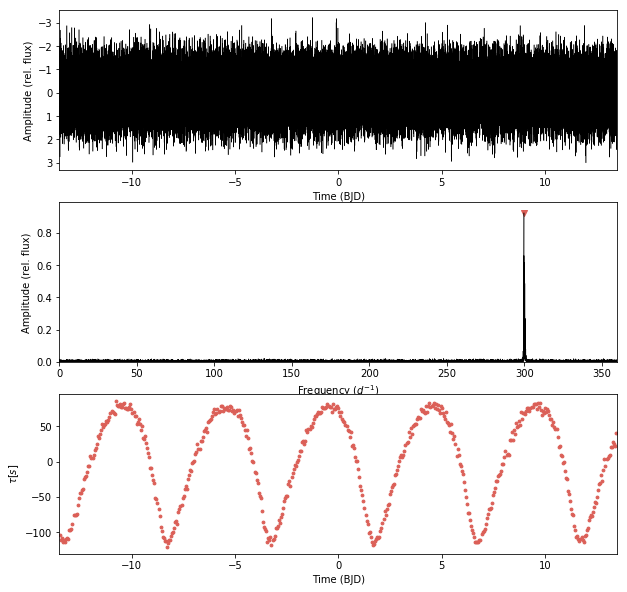

In [27]:
from maelstrom import Maelstrom
ms = Maelstrom(lc.time, lc.flux, 
               freq=freqs,
              )
ms.first_look(segment_size=0.05)